In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
import optuna



from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import coint, adfuller
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Phase 1: Using only Price Volume Data

In [63]:
pfe = yf.download('PFE',start="2010-01-01", end="2025-04-16" ,auto_adjust=False)[['Close','Volume']]


[*********************100%***********************]  1 of 1 completed


In [64]:
pfe_clean = pfe.copy()
pfe_clean.columns = ['Price','Volume']
pfe_clean = pfe_clean.reset_index()

df_full = pfe_clean[['Date','Price','Volume']]

In [192]:
train_start = '2010-01-01'
train_end   = '2018-12-31'
val_start   = '2019-01-01'
val_end     = '2022-12-31'

In [ ]:
train_mask = (df_full['Date'] >= train_start) & (df_full['Date'] <= train_end)
val_mask   = (df_full['Date'] >= val_start) & (df_full['Date'] <= val_end)
test_mask  = df_full['Date'] > val_end  


df = df_full[train_mask].reset_index(drop=True)
val_df   = df_full[val_mask].reset_index(drop=True)
test_df  = df_full[test_mask].reset_index(drop=True)

In [194]:
df.rename(columns={'Volume':'Volume OG'},inplace=True)
df.rename(columns={'Price':'Price OG'},inplace=True)

df['Price'], df['Volume'] = df['Price OG'].shift(), df['Volume OG'].shift()

In [79]:
def vwap(df):
# Volume-weighted returns over different periods
   vwap_5 = (df['Price'] * df['Volume']).rolling(5).sum() / df['Volume'].rolling(5).sum()
   vwap_20 = (df['Price'] * df['Volume']).rolling(20).sum() / df['Volume'].rolling(20).sum()



   vwap_diff = vwap_5 - vwap_20


   vwap_mean = vwap_diff.rolling(20).mean()
   vwap_std = vwap_diff.rolling(20).std()
   vwap_z = (vwap_diff - vwap_mean) / (vwap_std + 1e-6)

   # Cap extreme z-scores for stability
   return vwap_z.clip(-2, 2) / 2  # Range: ~[-1, 1]

In [39]:
def momentum(df):
    volume_ratio = df['Volume'] / df['Volume'].rolling(20).mean()
    price_change_5 = df['Price'].ffill().pct_change(5)
    vol_adj_momentum = price_change_5 * volume_ratio


    # Normalize using z-score or min-max:
    z = vol_adj_momentum.rolling(30)
    mean = z.mean()
    std = z.std()
    momentum_z = (vol_adj_momentum - mean) / (std + 1e-6)

    # Cap and scale to [-1, 1]
    return momentum_z.clip(-2, 2) / 2

In [40]:
def divergance(df):    
    def rolling_slope(series, window):
        X = np.arange(window).reshape(-1, 1)
        return series.rolling(window).apply(lambda y: LinearRegression().fit(X, y).coef_[0], raw=False)

    # Calculate slopes
    price_slope = rolling_slope(df['Price'], window=10)
    volume_slope = rolling_slope(df['Volume'], window=10)

    # Normalize both
    price_slope_z = (price_slope - price_slope.rolling(20).mean()) / price_slope.rolling(20).std()
    volume_slope_z = (volume_slope - volume_slope.rolling(20).mean()) / volume_slope.rolling(20).std()

    # Compute divergence signal: negative when opposing, positive when aligned
    return ((price_slope_z * volume_slope_z) / 3).clip(-1, 1)

In [41]:
def breakout(df):
    rolling_max = df['Price'].rolling(20).max().shift(1)
    rolling_min = df['Price'].rolling(20).min().shift(1)

    # Distance beyond breakout level (positive if breakout, else 0)
    breakout_up_dist = (df['Price'] - rolling_max).clip(lower=0)
    breakout_down_dist = (rolling_min - df['Price']).clip(lower=0)

    # Normalize breakout distances by rolling std to get z-like scores
    price_std_20 = df['Price'].rolling(20).std().shift(1).replace(0, np.nan)  # avoid div by zero

    breakout_up_z = breakout_up_dist / price_std_20
    breakout_down_z = breakout_down_dist / price_std_20

    # Volume percentile 
    volume_percentile = df['Volume'].rolling(50).rank(pct=True)

    # Weight breakout signals by volume percentile (scaled 0.8 to 1 range)
    vol_weight = ((volume_percentile - 0.8) / 0.2).clip(0,1)

    # Combine up and down breakout signals
    breakout_signal_raw = breakout_up_z * vol_weight - breakout_down_z * vol_weight

    # Clip final breakout signal to [-1,1]
    return  breakout_signal_raw.clip(-1, 1).fillna(0)

In [43]:
def obv(df):
    price_change = df['Price'].diff()
    obv = (df['Volume'] * np.where(price_change > 0, 1, -1)).cumsum()

    # Moving average and std
    obv_ma = obv.rolling(14).mean()
    obv_std = obv.rolling(14).std()

    # Signal: z-score of distance from OBV mean
    obv_z = (obv - obv_ma) / obv_std

    # Final signal scaled to [-1, 1]
    return  obv_z.clip(-2, 2) / 2

In [207]:
def vpt(df):   
    vpt = (df['Volume'] * df['Price'].pct_change()).cumsum()

    # Moving average and std dev of VPT
    vpt_ma = vpt.rolling(14).mean()
    vpt_std = vpt.rolling(14).std()

    # Signal: z-score of deviation from VPT mean
    vpt_z = (vpt - vpt_ma) / vpt_std

    # Final signal scaled to [-1, 1]
    return vpt_z.clip(-2, 2) / 2

In [ ]:
def regime_enhance(df):
    volume_ma = df['Volume'].rolling(50).mean()
    volume_std = df['Volume'].rolling(50).std()
    volume_regime = np.where(
        df['Volume'] > volume_ma + volume_std, 'high',
        np.where(df['Volume'] < volume_ma - volume_std, 'low', 'normal')
    )



    regime_multiplier = np.where(
    volume_regime == 'high', 1.5,      # Amplify in high volume
    np.where(volume_regime == 'low', 0.5, 1.0)  # Dampen in low volume
    )


    momentum_signal_enhanced = (momentum(df) * regime_multiplier).clip(-1, 1)




    # Volume regime confidence multiplier for breakouts
    breakout_confidence = np.where(
        volume_regime == 'high', 1.3,      # High confidence in high volume
        np.where(volume_regime == 'low', 0.6, 1.0)  # Low confidence in low volume
    )

    # Enhanced breakout signal
    breakout_signal_enhanced = (breakout(df) * breakout_confidence).clip(-1, 1)


    return momentum_signal_enhanced, breakout_signal_enhanced


In [28]:
def getPNS(df):
    
    price_N_signals = pd.DataFrame({
    'price': df['Price OG'],
    'vwap': vwap(df), 
    'momentum': regime_enhance(df)[0], 
    'divergence': divergance(df),
    'obv': obv(df),
    'vpt': vpt(df),
    'breakout': regime_enhance(df)[1]
    })

    return price_N_signals

In [29]:
def getFinalSignal(PNS,w,t):
    weighted_signal = (PNS[PNS.columns[1:7]] * w).sum(axis=1)
    final_signal = np.where(weighted_signal > t, 1, -1)
    return final_signal

In [56]:
def ApplyStrategy(df, final_signal):
    Strat_PNL= (df['Price OG'].diff().fillna(0) * final_signal * 1000000 / df['Price OG'].shift(1)).fillna(0)
    Strat_Wealth = 1000000 + Strat_PNL.cumsum()


    total_return = (Strat_Wealth.iloc[-1])/1000000


    periods_per_year = 252
    sharpe = (Strat_PNL.mean() / Strat_PNL.std()) * np.sqrt(periods_per_year)

    n_years = len(df) / periods_per_year
    cagr = (Strat_Wealth.iloc[-1]/Strat_Wealth.iloc[0])**(1/n_years)

    roll_max = Strat_Wealth.cummax()
    max_drawdown = (Strat_Wealth/roll_max - 1).min()

    return total_return, sharpe, cagr, max_drawdown, Strat_Wealth

In [32]:
def plotAll(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Strat_Wealth'], label='Strategy (Rebalanced)', linewidth=2)
    plt.plot(df['All_Long_Wealth'], label='Long Daily (Rebalanced)', linestyle='--')
    plt.plot(df['BNH Wealth'], label='Buy & Hold', linestyle=':')
    plt.xlabel("Date")
    plt.ylabel("Wealth")
    plt.legend()
    plt.title("Strategy vs Buy & Hold vs Long Daily")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [217]:
def getOptim(dataframe, PNS):
    
    def objective(trial):
    # Suggest weights w1 to w6 ∈ (0, 1)
        w = [trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(6)]
        

        w_sum = sum(w)
        w = [wi / w_sum for wi in w]
        

        t = trial.suggest_float("t", -1.0, 1.0)

        # Your black-box function
        try:
            ret = ApplyStrategy(dataframe, getFinalSignal(PNS, w, t))[0]
        except Exception as e:
            print("Error in getReturns:", e)
            return float('-inf')  # penalize failed attempts

        return ret  

    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000, show_progress_bar=False)

    # Best results
    best_w = [study.best_trial.params[f"w{i}"] for i in range(6)]
    w_sum = sum(best_w)
    best_w = [wi / w_sum for wi in best_w] 
    best_t = study.best_trial.params["t"]

    print("Best w:", best_w)
    print("Best t:", best_t)
    print("Max return:", study.best_value)

    return best_w, best_t

In [156]:
def simulate(df):

    PNS = getPNS(df).fillna(0)

    w,t = getOptim(df,PNS)

    final_signal = getFinalSignal(PNS, w,t)

    returns, sharpe, cagr, maxddr, stratWealth = ApplyStrategy(df, final_signal)

    print(f"Total return:{returns}")
    print(f"Sharpe:{sharpe}")
    print(f"CAGR:{cagr}")
    print(f"Max DrawDown:{maxddr}")

    df['Strat_Wealth'] = stratWealth

    Strat_PnL_allLong = df['Price OG'].diff() * 1000000 / df['Price OG'].shift(1)
    df['All_Long_Wealth'] = 1000000 + Strat_PnL_allLong.cumsum() 

    Ret = df['Price OG'].ffill().pct_change()
    df['BNH Wealth'] = 1000000 * (1 + Ret).cumprod()

    plotAll(df)

[I 2025-06-01 22:15:36,627] A new study created in memory with name: no-name-e964609f-fc5f-4887-af9b-489bfbc2cdd8
[I 2025-06-01 22:15:36,639] Trial 0 finished with value: 0.4172753132390964 and parameters: {'w0': 0.2941618993465531, 'w1': 0.5370291962268446, 'w2': 0.3945819839878201, 'w3': 0.0591717476271062, 'w4': 0.8490196230257803, 'w5': 0.012653774613456625, 't': -0.25706847662047005}. Best is trial 0 with value: 0.4172753132390964.
[I 2025-06-01 22:15:36,644] Trial 1 finished with value: 0.5594485000986658 and parameters: {'w0': 0.31489431963949777, 'w1': 0.3417000232586058, 'w2': 0.40031663659194616, 'w3': 0.7322481242785057, 'w4': 0.47887424736655726, 'w5': 0.24419327463189433, 't': -0.6762290298151632}. Best is trial 1 with value: 0.5594485000986658.
[I 2025-06-01 22:15:36,648] Trial 2 finished with value: -0.589652116525221 and parameters: {'w0': 0.569609515615431, 'w1': 0.9414660912878698, 'w2': 0.8469291221550638, 'w3': 0.8302498848346658, 'w4': 0.11898994276865116, 'w5': 0.

Best w: [0.1268341129827129, 0.21698776281610024, 0.2548596614418812, 0.1234778719627373, 0.1996019125742362, 0.07823867822233221]
Best t: -0.7265757704101413
Max return: 0.8277022100713646
Total return:2.36232445094586
Sharpe:0.8277022100713646
CAGR:1.1004123648785666
Max DrawDown:-0.3031371940349601


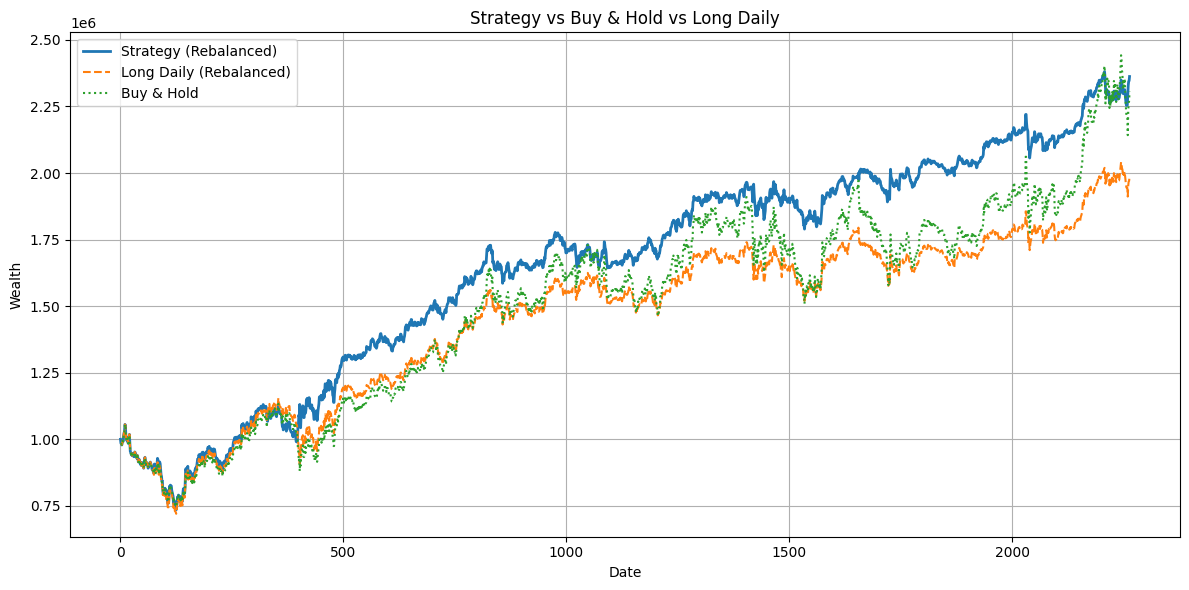

In [208]:
simulate(df)

## Phase 2: Using Competitor and Sector Analysis

In [157]:
competitors = ['JNJ', 'MRK', 'AZN', 'GSK', 'LLY', 'ABBV', 'BMY']
sectors = ['XLV', 'IHE']
target = 'PFE'

In [158]:
tickers = ['PFE', 'JNJ', 'MRK', 'AZN', 'GSK', 'LLY', 'XLV','ABBV','BMY','IHE']
data_full = yf.download(tickers, start="2010-01-01", end="2025-04-16",auto_adjust=False)['Close']

[*********************100%***********************]  10 of 10 completed


In [195]:

data_full = data_full.reset_index()

cols = ['Date'] + [col for col in data_full.columns if col != 'Date']
data_full = data_full[cols]


In [196]:
data = data_full[train_mask].reset_index(drop=True)
val_data   = data_full[val_mask].reset_index(drop=True)
test_data  = data_full[test_mask].reset_index(drop=True)

In [197]:
data['Price OG'] = data['PFE']
data[tickers] = data[tickers].shift(1)

In [162]:
def calculate_returns(data):
    window=1
    return data[tickers].pct_change(window).fillna(0)


In [163]:
def rolling_correlation_signal(data, returns):

    window=20
    
    # Calculate rolling correlation with sector ETFs
    pfe_xlv_corr = returns[target].rolling(window).corr(returns['XLV'])
    pfe_ihe_corr = returns[target].rolling(window).corr(returns['IHE'])
    
    # Average sector correlation
    avg_sector_corr = (pfe_xlv_corr + pfe_ihe_corr) / 2
    
    # Market regime detection using sector performance
    sector_returns = returns[sectors].mean(axis=1).rolling(window).mean()
    market_trend = np.where(sector_returns > 0, 1, -1)
    
    # Signal logic: high correlation in downtrends = sell, low correlation in uptrends = buy
    signal = np.where(market_trend > 0, 
                     -2 * (avg_sector_corr - 0.5),  # In uptrend, low correlation is good
                     2 * (avg_sector_corr - 0.5))   # In downtrend, high correlation is bad
    
    return np.where(np.isnan(np.clip(signal, -1, 1)),0,np.clip(signal, -1, 1))


In [164]:
def relative_strength_signal(data, returns):
    """
    Multi-dimensional relative strength signal comparing PFE to:
    1. Competitor average
    2. Sector ETFs
    3. Best/worst performer identification
    """
    window=20
    
    # Calculate rolling returns
    pfe_rolling = returns[target].rolling(window).mean()
    competitor_avg = returns[competitors].mean(axis=1).rolling(window).mean()
    sector_avg = returns[sectors].mean(axis=1).rolling(window).mean()
    
    # Relative strength vs competitors
    rs_competitors = (pfe_rolling - competitor_avg) / competitor_avg.rolling(window).std()
    
    # Relative strength vs sector
    rs_sector = (pfe_rolling - sector_avg) / sector_avg.rolling(window).std()
    
    # Combined relative strength
    combined_rs = (rs_competitors + rs_sector) / 2
    
    # Normalize to [-1, 1] using tanh
    signal = np.tanh(combined_rs / 2)
    
    return signal.fillna(0)

In [165]:
def cointegration_pairs_signal(data):
    """
    Cointegration-based signal using statistical arbitrage principles
    Identifies mean-reverting relationships with competitors
    """
    window = 60
    signals = []
    
    for i in range(window, len(data)):
        window_data = data.iloc[i-window:i]
        pfe_prices = window_data[target]
        
        pair_signals = []
        
        # Test cointegration with each competitor
        for competitor in competitors:
            try:
                competitor_prices = window_data[competitor]
                
                # Cointegration test
                _, pvalue, _ = coint(pfe_prices, competitor_prices)
                
                if pvalue < 0.05:  # Cointegrated
                    # Calculate spread
                    spread = pfe_prices - competitor_prices
                    spread_zscore = (spread.iloc[-1] - spread.mean()) / spread.std()
                    
                    # Mean reversion signal
                    pair_signal = -np.tanh(spread_zscore / 2)
                    pair_signals.append(pair_signal)
                    
            except:
                continue
        
        if pair_signals:
            signals.append(np.mean(pair_signals))
        else:
            signals.append(0)
    
    # Pad with zeros for initial window
    result = np.concatenate([np.zeros(window), signals])
    return result[:len(data)]



In [166]:
def sector_rotation_signal(data, returns):
    """
    Signal based on sector rotation patterns and PFE's position within healthcare
    """
    window = 30
    
    # Healthcare sector momentum
    xlv_momentum = returns['XLV'].rolling(window).mean()
    ihe_momentum = returns['IHE'].rolling(window).mean()
    sector_momentum = (xlv_momentum + ihe_momentum) / 2
    
    # PFE relative to sector momentum
    pfe_momentum = returns[target].rolling(window).mean()
    relative_momentum = pfe_momentum - sector_momentum
    
    # Sector strength ranking
    all_healthcare = returns[competitors + [target]]
    pfe_rank = all_healthcare.rolling(window).mean().rank(axis=1, pct=True)[target]
    
    # Combined signal
    momentum_signal = np.tanh(relative_momentum / relative_momentum.rolling(window*2).std())
    rank_signal = (pfe_rank - 0.5) * 2  # Convert to [-1, 1]
    
    signal = (momentum_signal + rank_signal) / 2
    return signal.fillna(0)

In [167]:
def beta_adjusted_signal(data, returns):
    """
    Signal based on beta relationships with sector and mean reversion
    """
    window = 60
    signals = []
    
    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]
        
        # Calculate beta with XLV
        pfe_returns = window_returns[target]
        xlv_returns = window_returns['XLV']
        
        try:
            beta_xlv = np.cov(pfe_returns, xlv_returns)[0,1] / np.var(xlv_returns)
            
            # Expected return based on beta
            expected_return = beta_xlv * xlv_returns.iloc[-1]
            actual_return = pfe_returns.iloc[-1]
            
            # Beta deviation signal
            beta_signal = np.tanh((actual_return - expected_return) / pfe_returns.std())
            signals.append(-beta_signal)  # Mean reversion
            
        except:
            signals.append(0)
    
    result = np.concatenate([np.zeros(window), signals])
    return result[:len(data)]

In [168]:
def volatility_regime_signal(data, returns):
    """
    Signal based on volatility regime changes across the sector
    """
    window=30
    # Calculate rolling volatilities
    pfe_vol = returns[target].rolling(window).std()
    competitor_vol = returns[competitors].rolling(window).std().mean(axis=1)
    sector_vol = returns[sectors].rolling(window).std().mean(axis=1)
    
    # Relative volatility
    rel_vol_competitors = (pfe_vol - competitor_vol) / competitor_vol
    rel_vol_sector = (pfe_vol - sector_vol) / sector_vol
    
    # Volatility regime signal (inverse relationship)
    signal = -np.tanh((rel_vol_competitors + rel_vol_sector) / 2)
    
    return signal.fillna(0)


In [169]:
def getPNS2(data):

    returns = calculate_returns(data)
    
    price_N_signals2 = pd.DataFrame({
    'price': data['Price OG'],
    'rc': rolling_correlation_signal(data,returns),
    'rss': relative_strength_signal(data,returns), 
    'coin': cointegration_pairs_signal(data), 
    'sector': sector_rotation_signal(data,returns),
    'beta': beta_adjusted_signal(data,returns),
    'vr': volatility_regime_signal(data,returns)
    })

    return price_N_signals2

In [170]:
def simulate2(df):

    PNS = getPNS2(df).fillna(0)

    w,t = getOptim(df,PNS)

    final_signal = getFinalSignal(PNS, w,t)

    returns, sharpe, cagr, maxddr, stratWealth = ApplyStrategy(df, final_signal)

    print(f"Total return:{returns}")
    print(f"Sharpe:{sharpe}")
    print(f"CAGR:{cagr}")
    print(f"Max DrawDown:{maxddr}")

    df['Strat_Wealth'] = stratWealth

    Strat_PnL_allLong = df['Price OG'].diff() * 1000000 / df['Price OG'].shift(1)
    df['All_Long_Wealth'] = 1000000 + Strat_PnL_allLong.cumsum() 

    Ret = df['Price OG'].ffill().pct_change()
    df['BNH Wealth'] = 1000000 * (1 + Ret).cumprod()

    plotAll(df)

[I 2025-06-01 23:05:45,963] A new study created in memory with name: no-name-c02e80d8-2e81-44b2-93cd-89f3d303f396
[I 2025-06-01 23:05:45,968] Trial 0 finished with value: 0.7658583688381077 and parameters: {'w0': 0.010789847133577557, 'w1': 0.725082009503721, 'w2': 0.2769963215192488, 'w3': 0.9067362101362734, 'w4': 0.010450541319178996, 'w5': 0.6397118476878987, 't': -0.0008439400096844629}. Best is trial 0 with value: 0.7658583688381077.
[I 2025-06-01 23:05:45,976] Trial 1 finished with value: 1.9862858277770798 and parameters: {'w0': 0.13216166996423329, 'w1': 0.29322955785883154, 'w2': 0.617010095054541, 'w3': 0.14782968714671674, 'w4': 0.3948565446216806, 'w5': 0.42342383078354384, 't': -0.9885831760621584}. Best is trial 1 with value: 1.9862858277770798.
[I 2025-06-01 23:05:45,980] Trial 2 finished with value: 1.9862858277770798 and parameters: {'w0': 0.5339643942000355, 'w1': 0.25180409381264546, 'w2': 0.40967890902169235, 'w3': 0.8732486735868733, 'w4': 0.26324275199356884, 'w5

Best w: [0.20897953359073365, 0.04683836451341847, 0.06415673179484097, 0.21375810820137814, 0.2394768783832402, 0.22679038351638858]
Best t: -0.13697143276819987
Max return: 3.1533770363798146
Total return:3.1533770363798146
Sharpe:1.3109932729641336
CAGR:1.1363639792870286
Max DrawDown:-0.11613746867214647


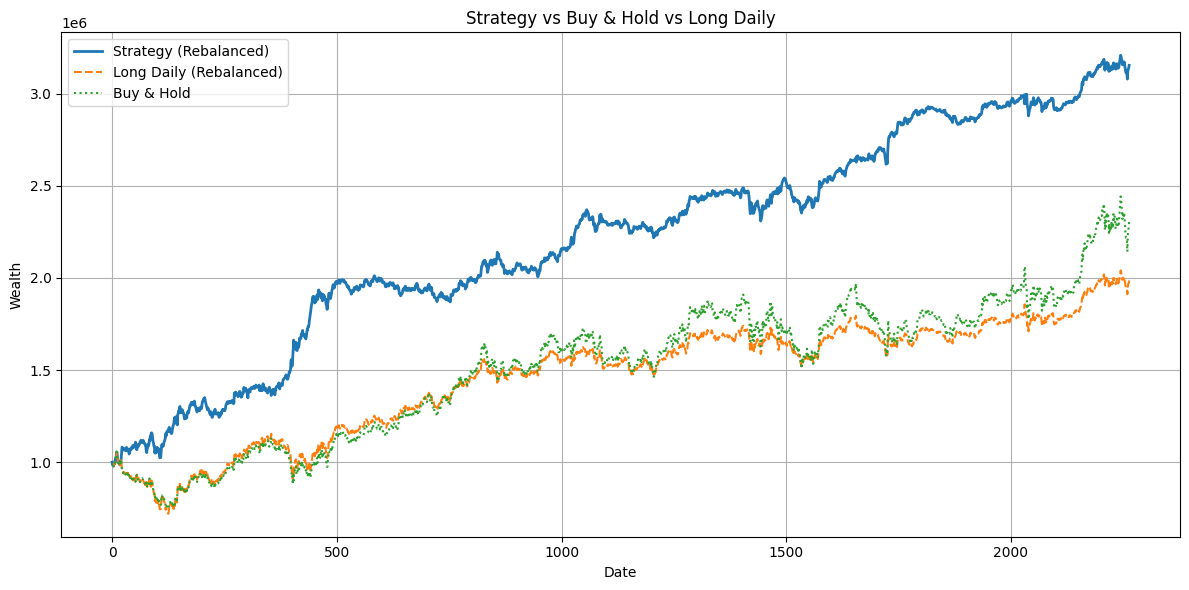

In [220]:
simulate2(data)

## Phase 3: Combining Signals

In [155]:
def getCombinedSignal(fs, fs2, w, t):
    combined_weight = fs*(w[0]) + fs2*(w[1])
    combined_signal = np.where(combined_weight > t, 1, -1)
    return combined_signal

In [ ]:
def getOptim3(dataframe, fs1, fs2):
    
    def objective(trial):
    # Suggest weights w1 to w6 ∈ (0, 1)
        w = [trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(2)]
        

        w_sum = sum(w)
        w = [wi / w_sum for wi in w]
        

        t = trial.suggest_float("t", -1.0, 1.0)

        try:
            ret = ApplyStrategy(dataframe, getCombinedSignal(fs1, fs2, w, t))[1]
        except Exception as e:
            print("Error in getReturns:", e)
            return float('-inf')  # penalize failed attempts

        return ret  

    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500, show_progress_bar=False)

    # Best results
    best_w = [study.best_trial.params[f"w{i}"] for i in range(2)]
    w_sum = sum(best_w)
    best_w = [wi / w_sum for wi in best_w] 
    best_t = study.best_trial.params["t"]

    print("Best w:", best_w)
    print("Best t:", best_t)
    print("Max return:", study.best_value)

    return best_w, best_t

In [198]:
def simulate3(df, data):
    PNS = getPNS(df).fillna(0)
    PNS2 = getPNS2(data).fillna(0)

    w1,t1 = getOptim(df,PNS)
    w2,t2 = getOptim(data,PNS2)

    fs1 = getFinalSignal(PNS, w1,t1)
    fs2 = getFinalSignal(PNS2, w2,t2)

    w,t = getOptim3(df,fs1,fs2)

    combined_signal = getCombinedSignal(fs1, fs2, w,t)
    
    returns, sharpe, cagr, maxddr, stratWealth = ApplyStrategy(df, combined_signal)

    print(f"Total return:{returns}")
    print(f"Sharpe:{sharpe}")
    print(f"CAGR:{cagr}")
    print(f"Max DrawDown:{maxddr}")

    df['Strat_Wealth'] = stratWealth

    Strat_PnL_allLong = df['Price OG'].diff() * 1000000 / df['Price OG'].shift(1)
    df['All_Long_Wealth'] = 1000000 + Strat_PnL_allLong.cumsum() 

    Ret = df['Price OG'].ffill().pct_change()
    df['BNH Wealth'] = 1000000 * (1 + Ret).cumprod()

    plotAll(df)

    return w1, t1, w2, t2, w, t
    

[I 2025-06-01 23:02:42,896] A new study created in memory with name: no-name-79357ce8-e4df-4aae-b6fc-8f5708b3da83
[I 2025-06-01 23:02:42,911] Trial 0 finished with value: 1.8188118511453146 and parameters: {'w0': 0.16770955108226238, 'w1': 0.0802807939644622, 'w2': 0.9178063144120147, 'w3': 0.7661682869846435, 'w4': 0.5047735814618415, 'w5': 0.6462229454721122, 't': -0.49697252852027596}. Best is trial 0 with value: 1.8188118511453146.
[I 2025-06-01 23:02:42,911] Trial 1 finished with value: 0.08057480949248781 and parameters: {'w0': 0.19515916188606897, 'w1': 0.31947015730987505, 'w2': 0.9340322432007776, 'w3': 0.2701635167575849, 'w4': 0.8520489936772154, 'w5': 0.6259745695580585, 't': 0.90635576034733}. Best is trial 0 with value: 1.8188118511453146.
[I 2025-06-01 23:02:42,925] Trial 2 finished with value: 1.7909874897709364 and parameters: {'w0': 0.6310190530773411, 'w1': 0.919545357040231, 'w2': 0.018039203690982553, 'w3': 0.04114386486020116, 'w4': 0.823619983123653, 'w5': 0.0638

Best w: [0.08873007535286112, 0.42754782552844595, 0.2765688284677797, 0.166409437372732, 0.024012152809337096, 0.016731680468844285]
Best t: -0.5621082407591443
Max return: 2.4359982869933665


[I 2025-06-01 23:03:26,924] Trial 16 finished with value: 2.0663735323885692 and parameters: {'w0': 0.19907260022123896, 'w1': 0.011879745603586955, 'w2': 0.7977336828561301, 'w3': 0.2895730323949998, 'w4': 0.8400314892419083, 'w5': 0.843521699908938, 't': -0.1479912478873453}. Best is trial 16 with value: 2.0663735323885692.
[I 2025-06-01 23:03:26,963] Trial 17 finished with value: 2.1416435981316493 and parameters: {'w0': 0.18434371524434273, 'w1': 0.6361387088557747, 'w2': 0.8412995139965841, 'w3': 0.290502230086333, 'w4': 0.6431372450658366, 'w5': 0.8371236329393872, 't': -0.15407851862627542}. Best is trial 17 with value: 2.1416435981316493.
[I 2025-06-01 23:03:26,980] Trial 18 finished with value: 1.715960831991017 and parameters: {'w0': 0.17795966114041564, 'w1': 0.006100536250456635, 'w2': 0.6869416106160734, 'w3': 0.13702339386573292, 'w4': 0.6055411211576056, 'w5': 0.8364395092512332, 't': -0.0807620819047096}. Best is trial 17 with value: 2.1416435981316493.
[I 2025-06-01 23

Best w: [0.2709199989715973, 0.03646425736365868, 0.043233152488653843, 0.08457772150194168, 0.2175274975668061, 0.3472773721073424]
Best t: -0.08147668207419075
Max return: 3.3247226318475036


[I 2025-06-01 23:04:14,238] Trial 19 finished with value: 1.38089695338544 and parameters: {'w0': 0.5351220997799566, 'w1': 0.4413468272670307, 't': 0.1736933825647124}. Best is trial 0 with value: 1.4161095160606831.
[I 2025-06-01 23:04:14,263] Trial 20 finished with value: 0.9075664964607874 and parameters: {'w0': 0.7121272146567938, 'w1': 0.5840337418982839, 't': -0.2807375369473719}. Best is trial 0 with value: 1.4161095160606831.
[I 2025-06-01 23:04:14,281] Trial 21 finished with value: 1.4161095160606831 and parameters: {'w0': 0.2736204050020965, 'w1': 0.6903597740601262, 't': -0.08504302627839858}. Best is trial 0 with value: 1.4161095160606831.
[I 2025-06-01 23:04:14,299] Trial 22 finished with value: 1.4161095160606831 and parameters: {'w0': 0.21076146504658178, 'w1': 0.8199320051954917, 't': -0.06998271681703594}. Best is trial 0 with value: 1.4161095160606831.
[I 2025-06-01 23:04:14,314] Trial 23 finished with value: 0.9075664964607874 and parameters: {'w0': 0.32503753218358

Best w: [0.18450589158712152, 0.8154941084128785]
Best t: 0.07718939730336838
Max return: 1.4161095160606831
Total return:3.3247226318475036
Sharpe:1.4161095160606831
CAGR:1.1430763776684325
Max DrawDown:-0.11321561562579996


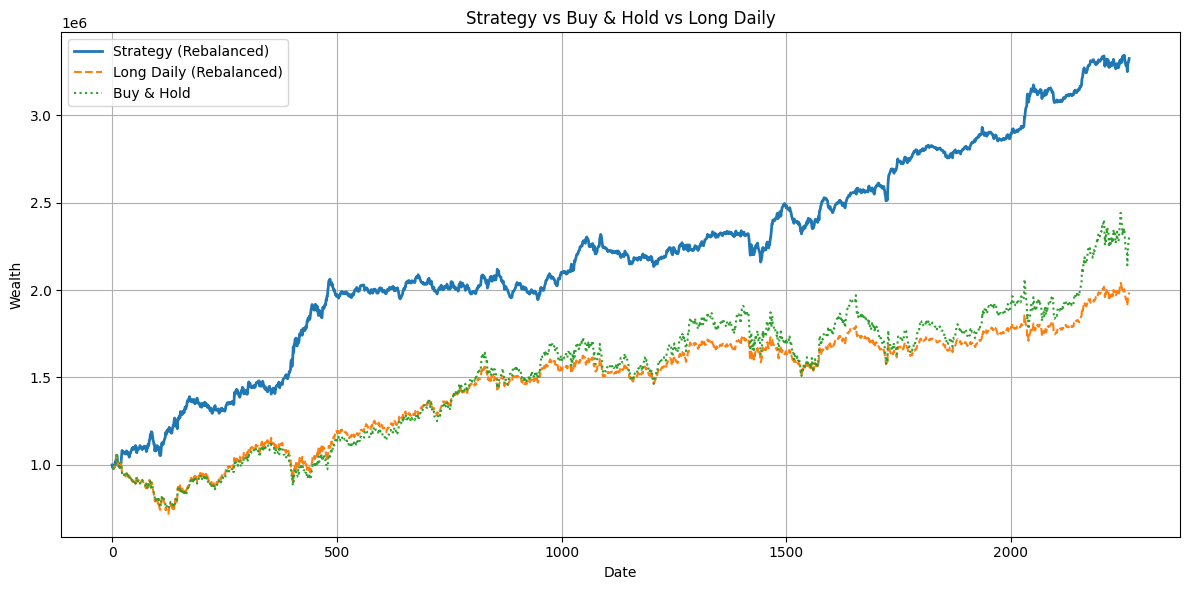

In [219]:
w1, t1, w2, t2, w, t = simulate3(df, data)

## Phase 4 Testing

In [201]:
test_df.rename(columns={'Volume':'Volume OG'},inplace=True)
test_df.rename(columns={'Price':'Price OG'},inplace=True)
test_df['Price'], test_df['Volume'] = test_df['Price OG'].shift(), test_df['Volume OG'].shift()

test_data['Price OG'] = test_data['PFE']
test_data[tickers] = test_data[tickers].shift(1)

In [204]:
def test(test_df, test_data,w1,t1,w2,t2,w,t):
    PNS = getPNS(test_df)
    fs1 = getFinalSignal(PNS, w1,t1)

    PNS2 = getPNS2(test_data)
    fs2 = getFinalSignal(PNS2, w2,t2)

    combined_signal = getCombinedSignal(fs1, fs2, w, t)

    returns, sharpe, cagr, maxddr, stratWealth = ApplyStrategy(test_df, combined_signal)

    print(f"Total return:{returns}")
    print(f"Sharpe:{sharpe}")
    print(f"CAGR:{cagr}")
    print(f"Max DrawDown:{maxddr}")

    test_df['Strat_Wealth'] = stratWealth

    Strat_PnL_allLong = test_df['Price OG'].diff() * 1000000 / test_df['Price OG'].shift(1)
    test_df['All_Long_Wealth'] = 1000000 + Strat_PnL_allLong.cumsum() 

    Ret = test_df['Price OG'].ffill().pct_change()
    test_df['BNH Wealth'] = 1000000 * (1 + Ret).cumprod()

    plotAll(test_df)



Total return:1.2037992862187652
Sharpe:0.3789400910483909
CAGR:1.0849929740428574
Max DrawDown:-0.22312214365498917


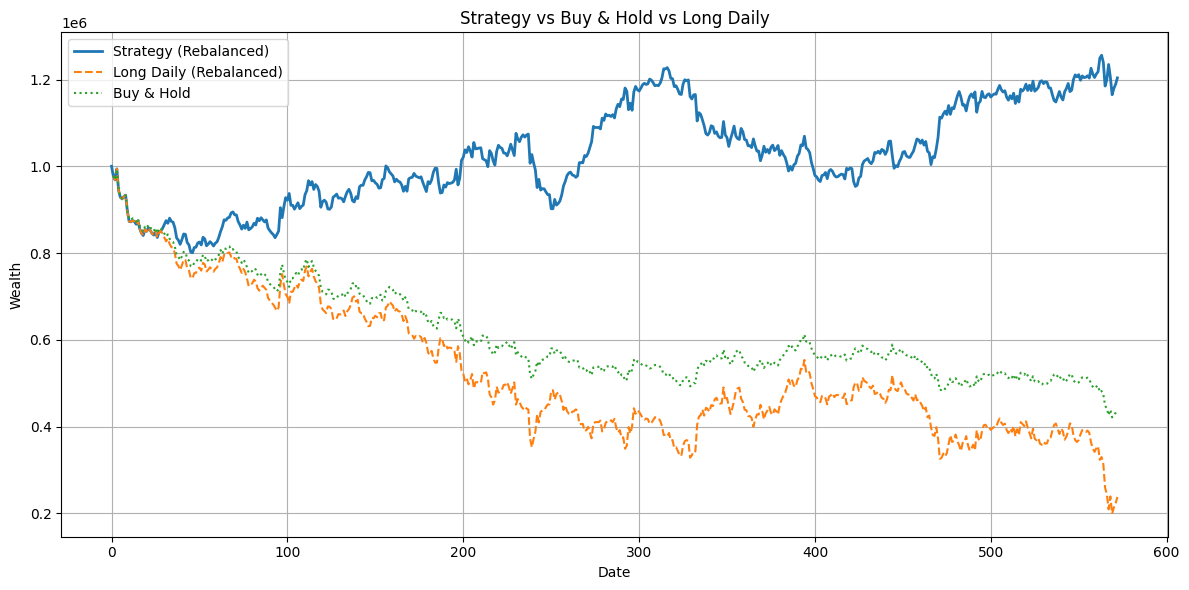

In [205]:
test(test_df, test_data,w1,t1,w2,t2,w,t)